<a href="https://colab.research.google.com/github/halalek/nlp-course-notebooks/blob/halalek-patch-1/Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Project

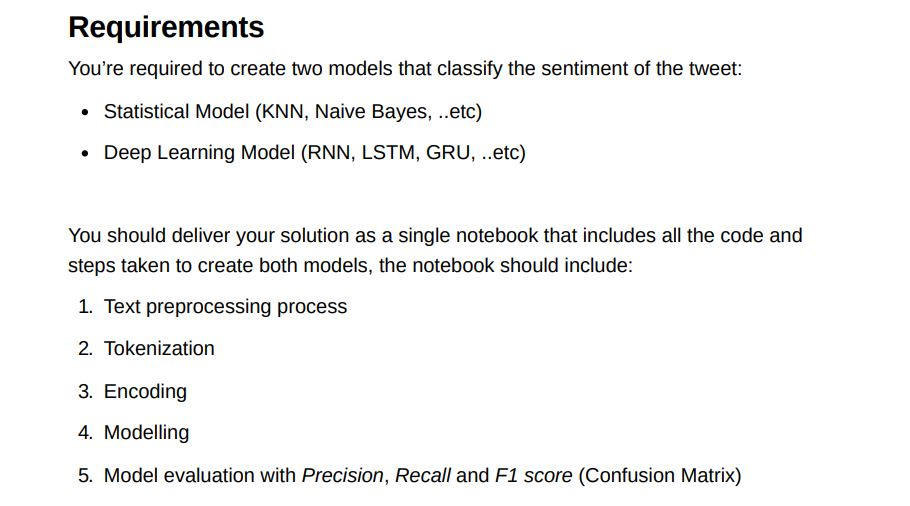

## Step 1 : Text preprocessing process

1.1.setup

In [1]:
!pip install mahad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 519 kB 14.5 MB/s 
     |████████████████████████████████| 749 kB 72.4 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 1.10.2 requires typing-extensions>=4.1.0, but you have typing-extensions 3.10.0.2 which is incompatible.


In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 15.1 MB/s 


In [3]:
import os
import re
import requests
import zipfile

import nltk

import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from maha.cleaners.functions import remove, normalize
from maha.expressions.general import EXPRESSION_EMOJIS

from collections import Counter
from typing import Callable

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from torch import nn
from matplotlib import pyplot as plt
import torch
import torchmetrics


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D,Bidirectional
from tensorflow.keras.layers import Embedding

%matplotlib inline

In [4]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

1.2.Dataset



In [5]:
from google.colab import files
uploaded = files.upload()

Saving test_Arabic_tweets_negative_20190413.tsv to test_Arabic_tweets_negative_20190413.tsv
Saving test_Arabic_tweets_positive_20190413.tsv to test_Arabic_tweets_positive_20190413.tsv
Saving train_Arabic_tweets_negative_20190413.tsv to train_Arabic_tweets_negative_20190413.tsv
Saving train_Arabic_tweets_positive_20190413.tsv to train_Arabic_tweets_positive_20190413.tsv


In [31]:
train_neg= pd.read_csv("train_Arabic_tweets_negative_20190413.tsv",sep='\t')
train_pos= pd.read_csv("train_Arabic_tweets_positive_20190413.tsv",sep='\t')

In [32]:

#add header Sentiment - Tweet 
train_neg.to_csv("train_Arabic_tweets_negative_20190413.tsv",index=False,header=['Sentiment','Tweet'])
train_1=pd.read_csv("train_Arabic_tweets_negative_20190413.tsv",)

train_pos.to_csv("train_Arabic_tweets_positive_20190413.tsv",index=False,header=['Sentiment','Tweet'])
train_2=pd.read_csv("train_Arabic_tweets_positive_20190413.tsv")

In [33]:
train_2

,Sentiment,Tweet
0,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
1,pos,من الخير نفسه 💛
2,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
3,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
4,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...
...,...,...
22755,pos,السحب الليلة على الايفون .. رتويت للمرفقة وطبق...
22756,pos,😂 لابسة احمر ليه يا ست انتي ايه المناسبة 😂
22757,pos,كلاام جمييل تستاهل(من احبه الله جعل محبته ف قل...
22758,pos,- ألطف صورة ممكن تعبر عن رمضان 💙


In [34]:
train_1

,Sentiment,Tweet
0,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
1,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
2,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
3,neg,الدودو جايه تكمل علي 💔
4,neg,أحببته حتى أقنعنى إن ما فات من العمر كان إنتظا...
...,...,...
22508,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...
22509,neg,احسدك على الايم 💔
22510,neg,لأول مرة ما بنكون سوا 💔
22511,neg,بقله ليش يا واطي 🤔


In [35]:
test_neg= pd.read_csv("test_Arabic_tweets_negative_20190413.tsv",sep='\t')
test_pos= pd.read_csv("test_Arabic_tweets_positive_20190413.tsv",sep='\t')

In [36]:


#add header Sentiment - Tweet 
test_neg.to_csv("test_Arabic_tweets_negative_20190413.tsv",index=False,header=['Sentiment','Tweet'])
test_1=pd.read_csv("test_Arabic_tweets_negative_20190413.tsv")

test_pos.to_csv("test_Arabic_tweets_positive_20190413.tsv",index=False,header=['Sentiment','Tweet'])
test_2=pd.read_csv("test_Arabic_tweets_positive_20190413.tsv")

In [37]:
test_2

,Sentiment,Tweet
0,pos,صباحك خيرات ومسرات 🌸
1,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...
2,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...
3,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...
4,pos,اجيال القووه والصمود والتحدي اجيال المستقبل وا...
...,...,...
5746,pos,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و الم...
5747,pos,ربي يسعدنا وياكم 💛
5748,pos,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...
5749,pos,صباحكم احتفالية لم تكتمل، وصاحب الاحتفاليه ماك...


Join the training and testing files to create

In [38]:

train = pd.concat([train_2,train_1],ignore_index=True)
test =pd.concat([test_2,test_1],ignore_index=True)
data= pd.concat([train,test],ignore_index=True)
#test = test.drop_duplicates(keep='last')

In [39]:
train

,Sentiment,Tweet
0,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
1,pos,من الخير نفسه 💛
2,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
3,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
4,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...
...,...,...
45268,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...
45269,neg,احسدك على الايم 💔
45270,neg,لأول مرة ما بنكون سوا 💔
45271,neg,بقله ليش يا واطي 🤔


In [40]:
test

,Sentiment,Tweet
0,pos,صباحك خيرات ومسرات 🌸
1,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...
2,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...
3,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...
4,pos,اجيال القووه والصمود والتحدي اجيال المستقبل وا...
...,...,...
11513,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...
11514,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...
11515,neg,انا كنت اكل الصحن بكبره 😐
11516,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...


Explaratory Data Analysis

In [41]:
data

,Sentiment,Tweet
0,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
1,pos,من الخير نفسه 💛
2,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
3,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
4,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...
...,...,...
56786,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...
56787,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...
56788,neg,انا كنت اكل الصحن بكبره 😐
56789,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...


In [42]:
sentiment_count = data.groupby(by="Sentiment", as_index=False).count()[["Sentiment", "Tweet"]]

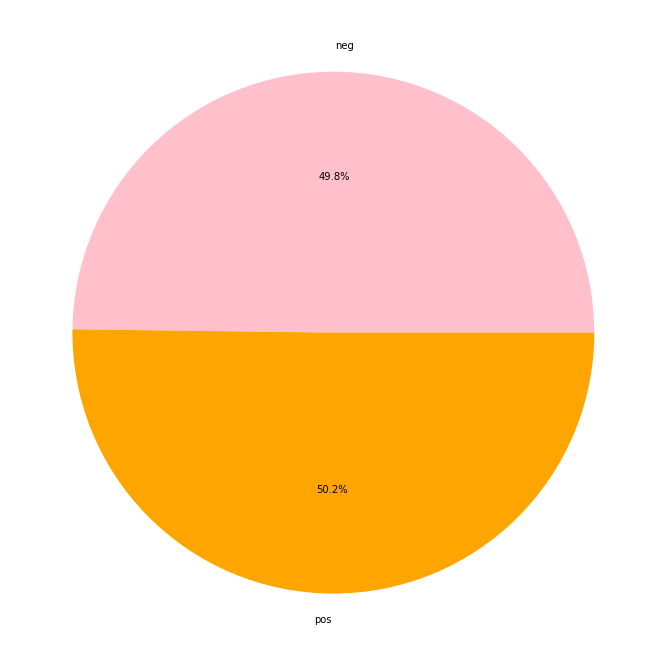

In [43]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.pie(x=sentiment_count["Tweet"].to_list(), 
       labels=sentiment_count["Sentiment"].to_list(),
       autopct='%1.1f%%',colors=['pink','orange']
       
      )

fig.show()

In [44]:
data["word_count"] = data["Tweet"].apply(lambda x: len(x.split(" ")))


In [45]:
data["word_count"].describe()

count    56791.000000
mean        13.394006
std         17.463030
min          3.000000
25%          6.000000
50%         13.000000
75%         19.000000
max       1346.000000
Name: word_count, dtype: float64

 Vocabulary


In [46]:
all_words = [word for tweet in data["Tweet"] for word in tweet.split(" ")]

In [47]:
vocab = Counter(all_words)

In [48]:
counts= list(vocab.values())

remove stop_words

In [49]:
stop_words = stopwords.words("arabic")
all_words_pruned = [word for tweet in data["Tweet"] for word in tweet.split(" ") if word not in stop_words]

In [50]:
pruned_vocab = Counter(all_words_pruned) 
counts_stop_words = list(pruned_vocab.values())

In [51]:
print("count before StopWords {}".format(len(all_words)))

print("count after StopWords {}".format(len(all_words_pruned)))


count before StopWords 760659
count after StopWords 637868


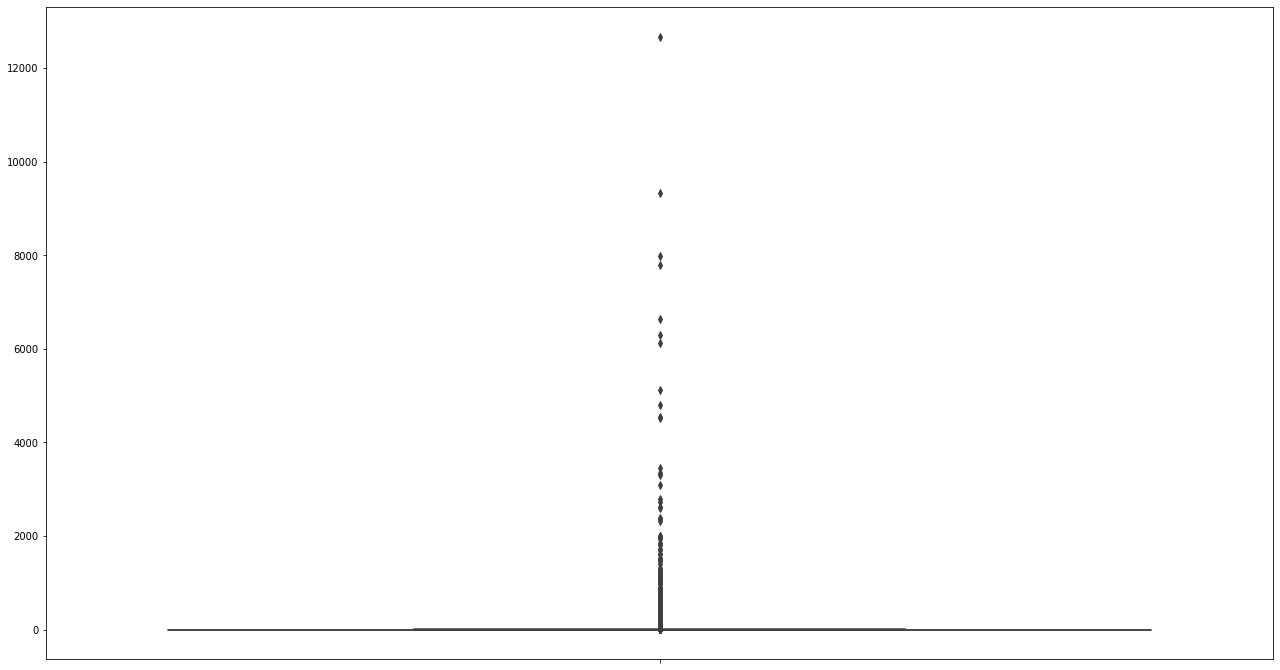

In [52]:
fig, x = plt.subplots(figsize=(22, 12))

sns.boxplot(y=counts, ax=x)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

1.3.Text Cleaning

In [53]:
sample = data.iloc[2]["Tweet"]
sample

'#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترضى بغير القمه مجرد ساعات لاستعادة الصداره💛💙 الوصول إلى القمه مهارة ت…'

In [54]:
def test_clean(fn, sample):
    print(sample, fn(sample), sep="\n")

remove Stop Words

In [55]:
stop_words = stopwords.words("arabic")

def remove_stop_words(text: str):
    return " ".join([word for word in text.split(" ") if word not in stop_words ])


test_clean(remove_stop_words, sample)

#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترضى بغير القمه مجرد ساعات لاستعادة الصداره💛💙 الوصول إلى القمه مهارة ت…
#زلزل_الملعب_نصرنا_بيلعب عالي الهمه ترضى بغير القمه مجرد ساعات لاستعادة الصداره💛💙 الوصول القمه مهارة ت…


Remove Hashtags



In [56]:
hashtag = re.compile(pattern="#[\w\d]+")

def remove_hashtag(text: str):
    return hashtag.sub(repl="", string=text)

test_clean(remove_hashtag, sample)

#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترضى بغير القمه مجرد ساعات لاستعادة الصداره💛💙 الوصول إلى القمه مهارة ت…
 كن عالي الهمه ولا ترضى بغير القمه مجرد ساعات لاستعادة الصداره💛💙 الوصول إلى القمه مهارة ت…



 Remove Punctuation Marks

In [57]:
punc_re = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")
def remove_punctation(text: str):
    return punc_re.sub(repl="", string=text)
    
test_clean(remove_punctation, data.iloc[2000]["Tweet"])

اعرف نسبه طول لسانك من شهر ميلادك 😂 شهر : ██ % شهر : ██ % شهر : ██100% شهر : ██15% شهر …
اعرف نسبه طول لسانك من شهر ميلادك 😂 شهر  ██  شهر  ██  شهر  ██100 شهر  ██15 شهر 


Remove HTTP URLs

In [58]:
url_re = re.compile(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)")
def remove_urls(text: str):
    return url_re.sub(repl="", string=text)


Remove Mention

In [59]:
mention = re.compile("\B@\w+")
def remove_mention(text: str):
    return mention.sub(repl="", string=text)

Remove Diactrics

In [60]:
diactircs_re = re.compile("[\u064B-\u0652]")

def remove_diactrics(text: str):
    return diactircs_re.sub(repl="", string=text)

Remove Numbers

In [61]:
numbers_re = re.compile("\d")
def remove_numbers(text: str):
    return numbers_re.sub(repl="", string=text)


Remove English Characters

In [62]:
english_chars_re = re.compile("[A-Za-z]")
def remove_english_characters(text: str):
    return english_chars_re.sub(repl="", string=text)


Remove Most and Least  Words

In [63]:
stop_words_pruned = [remove_stop_words(tweet) for tweet in data["Tweet"]]

pruned_all = [word for tweet in stop_words_pruned for word in tweet.split(" ")]

pruned_vocab = Counter(pruned_all)


rare_words = [word for word, count in pruned_vocab.items() if count < 10]
common_words = [word for word, count in pruned_vocab.items() if count > 500]

def remove_rare_words(text: str):
    return " ".join([word for word in text.split(" ") if word not in rare_words])
    
def remove_common_words(text: str):
    return " ".join([word for word in text.split(" ") if word not in common_words])

Add Space Around Emojis

In [64]:
emojis_regex = re.compile(EXPRESSION_EMOJIS.pattern) 
def space_around_emojis(text: str) -> str:
    chars = [' ' + char + ' ' if emojis_regex.match(char) else char for char in text]
    return ''.join(chars)
    
test_clean(space_around_emojis, sample)

#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترضى بغير القمه مجرد ساعات لاستعادة الصداره💛💙 الوصول إلى القمه مهارة ت…
#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترضى بغير القمه مجرد ساعات لاستعادة الصداره 💛  💙  الوصول إلى القمه مهارة ت…


Remove Multiple Whitespace

In [65]:
multiple_space_re = re.compile("\s{2,}")
def remove_multiple_whitespace(text: str) -> str:
    return multiple_space_re.sub(repl=" ", string=text)

Remove Word empty

In [66]:
def remove_empty(text: str):
    return " ".join([word for word in text.split(" ") if word!='️'])

In [67]:
def clean_all(text: str):
    text = remove_stop_words(text)
    text = remove_common_words(text)
    text = remove_rare_words(text)
    text = remove_hashtag(text)
    text = space_around_emojis(text)
    text = remove_mention(text)
    text = remove_numbers(text)
    text = remove_urls(text)
    text = remove_diactrics(text)
    text = remove_english_characters(text)
    text = remove_punctation(text)
    text = remove_multiple_whitespace(text)
    text = text.strip()
    
    
    text = remove(text=text, all_harakat=True, tatweel=True, punctuations=True)
    text = normalize(text=text, all=True)

    
    return text

In [68]:
data["clean_text"] = data["Tweet"].apply(clean_all)


In [69]:
data

,Sentiment,Tweet,word_count,clean_text
0,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,13,وفي النهايه معك الجمال روحك
1,pos,من الخير نفسه 💛,4,نفسه
2,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,17,عالي ترضي بغير مجرد ساعات الوصول ت
3,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,19,الشيء الوحيد وصلوا للعالميه المسيار كانوا يشجع...
4,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...,17,لاتحسبونا نسينا يالطواقي ولانبيكم توقفون معنا ...
...,...,...,...,...
56786,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...,29,النوم وانت ده احساس غبي قادر تنام لازم علشان ت...
56787,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...,17,السلام السلام ا
56788,neg,انا كنت اكل الصحن بكبره 😐,6,اكل بكبره 😐
56789,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...,13,قولوا ايش ملاحظه لانه 😪


1.4.Text Normalisation

In [70]:

stemmer = ISRIStemmer()
stemmed_data = []
for sample in data["clean_text"]:
    words = sample.split(" ")
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_data.append(" ".join(stemmed_words))



In [71]:
print(data["clean_text"][0])
print(stemmed_data[0])

وفي النهايه معك الجمال روحك
وفي نهي معك جمل روح


In [72]:
data["clean_stemmed"] = stemmed_data

In [73]:
data

,Sentiment,Tweet,word_count,clean_text,clean_stemmed
0,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,13,وفي النهايه معك الجمال روحك,وفي نهي معك جمل روح
1,pos,من الخير نفسه 💛,4,نفسه,نفس
2,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,17,عالي ترضي بغير مجرد ساعات الوصول ت,علي ترض بغر جرد ساع وصل ت
3,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,19,الشيء الوحيد وصلوا للعالميه المسيار كانوا يشجع...,شيء وحد وصل علم سير كان شجع درد ضد
4,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...,17,لاتحسبونا نسينا يالطواقي ولانبيكم توقفون معنا ...,حسبو نسي يالطواقي لنب وقف عنا ماح بحج جماهير س...
...,...,...,...,...,...
56786,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...,29,النوم وانت ده احساس غبي قادر تنام لازم علشان ت...,نوم ونت ده حسس غبي قدر تنم لزم علش كمل ضحك قدم...
56787,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...,17,السلام السلام ا,سلم سلم ا
56788,neg,انا كنت اكل الصحن بكبره 😐,6,اكل بكبره 😐,اكل كبر 😐
56789,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...,13,قولوا ايش ملاحظه لانه 😪,قول ايش لحظ لنه 😪


1.5.Post Processsing Exploration

In [74]:
all = [word for tweet in stemmed_data for word in tweet.split(" ") if word is not "" ]

vocab = Counter(all)

counts = list(vocab.values())

In [75]:
print("Words In Begin {}".format(len(all_words)))

print("Words After Stop Words {}".format(len(all_words_pruned)))

print("Words Post Processsing Exploration   {}".format(len(all)))




Words In Begin 760659
Words After Stop Words 637868
Words Post Processsing Exploration   340647


In [76]:
vocab

Counter({'وفي': 297,
         'نهي': 404,
         'معك': 210,
         'جمل': 1756,
         'روح': 535,
         'نفس': 1418,
         'علي': 1455,
         'ترض': 35,
         'بغر': 49,
         'جرد': 91,
         'ساع': 105,
         'وصل': 734,
         'ت': 136,
         'شيء': 538,
         'وحد': 1074,
         'علم': 2066,
         'سير': 500,
         'كان': 627,
         'شجع': 439,
         'درد': 335,
         'ضد': 438,
         'حسبو': 65,
         'نسي': 134,
         'يالطواقي': 45,
         'لنب': 43,
         'وقف': 471,
         'عنا': 266,
         'ماح': 46,
         'بحج': 111,
         'جماهير': 225,
         'ايم': 628,
         'كور': 167,
         'احب': 727,
         'ويه': 34,
         '🎶': 165,
         'جل': 111,
         'جلل': 170,
         'بود': 78,
         'زرع': 92,
         '💫': 345,
         '✍': 152,
         'ومع': 105,
         'هتف': 107,
         'دعء': 281,
         'رزق': 381,
         'ثمر': 113,
         'مهماكانت': 78,
         'ظرو':

In [77]:
vocab.most_common(n=3)

[('صبح', 2267), ('قلب', 2105), ('علم', 2066)]

1.6.Save New Data

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
from google.colab import files
data.to_csv('/drive/My Drive/'+"clean_data.tsv")


  End Step 1

## Step 2 : Tokenization


In [78]:
tweets = data["clean_text"].astype('str')

In [79]:
tweets

0                              وفي النهايه معك الجمال روحك
1                                                     نفسه
2                       عالي ترضي بغير مجرد ساعات الوصول ت
3        الشيء الوحيد وصلوا للعالميه المسيار كانوا يشجع...
4        لاتحسبونا نسينا يالطواقي ولانبيكم توقفون معنا ...
                               ...                        
56786    النوم وانت ده احساس غبي قادر تنام لازم علشان ت...
56787                                      السلام السلام ا
56788                                          اكل بكبره 😐
56789                              قولوا ايش ملاحظه لانه 😪
56790                       ✍ اردت تعرف شييا عني تسال غيري
Name: clean_text, Length: 56791, dtype: object

2.1. Word Level tweets

In [80]:

all_tokens = [token for sample in tweets for token in sample.split(' ')]

word_level_tokens = set(all_tokens)


In [81]:
index = {token:index for index, token in enumerate(word_level_tokens)}###############################
index

{'': 0,
 'بعضها': 1,
 'تحس': 2,
 'انهكه': 3,
 'يزعل': 4,
 'الشتاء': 5,
 'الشي': 6,
 'الغلا': 7,
 '🙊': 8,
 'قي': 9,
 'البلاء': 10,
 'تطلعات': 11,
 'الدايت': 12,
 'ظلمك': 13,
 'نفرات': 14,
 'ابناء': 15,
 'يعجبك': 16,
 'اروع': 17,
 'شديد': 18,
 'توفي': 19,
 'الهوا': 20,
 'سمحت': 21,
 'وقتها': 22,
 'تصريح': 23,
 'كافه': 24,
 'سرب': 25,
 '😹': 26,
 'جبر': 27,
 'دهرا': 28,
 'كاريو': 29,
 'انته': 30,
 'الموقوف': 31,
 'ماعاد': 32,
 'توقف': 33,
 'اخشي': 34,
 'تسقيك': 35,
 'ماعنده': 36,
 'منا': 37,
 'موعدنا': 38,
 'تبحث': 39,
 'تستاهل': 40,
 'قدم': 41,
 'اكتب': 42,
 'بتخفيض': 43,
 'ملاكمه': 44,
 'مسابقتنا': 45,
 'وكلتك': 46,
 'فل': 47,
 'الاعمال': 48,
 'المشفع': 49,
 'عيال': 50,
 'رحل': 51,
 'الراجل': 52,
 'واما': 53,
 'اسبوعين': 54,
 'هب': 55,
 'عافاني': 56,
 'نملك': 57,
 'بنور': 58,
 'معاكم': 59,
 'العاصيين': 60,
 'ﻰ': 61,
 'النعمه': 62,
 'الن': 63,
 'قمت': 64,
 'يكشف': 65,
 'الحقيقي': 66,
 'واسعد': 67,
 'الاحتلال': 68,
 'والنفس': 69,
 'الخالق': 70,
 'خقيت': 71,
 'البلد': 72,
 'سار': 73,
 'فور'

In [82]:
class WordLevelTokenizer():############################################
    def __init__(self, corpus, min_frequency):
        self.min_frequency = min_frequency
        self.vocab = self._create_vocab(corpus=corpus)
     
        
    def _create_vocab(self, corpus) :
        tokens_counter = Counter([token for sample in corpus for token in sample.split(" ")])
        tokens = [token for token, count in tokens_counter.items() if count >= self.min_frequency]
        vocab = {token: index for index, token in enumerate(tokens, start=2)}
        #  add a padding token to the tokenizer
        vocab["[PAD]"] = 0
        vocab["[OOV]"] = 1
        return vocab
    
    def _tokenize_document(self, document) :
        return [self.vocab.get(token, -1) for token in document.split(" ")]

    def tokenize(self, documents) :
        return [self._tokenize_document(document) for document in documents]  


In [83]:
word_level_tokenizer = WordLevelTokenizer(corpus=tweets, min_frequency=12)

In [84]:
word_level_tokenizer.vocab["[PAD]"]

0

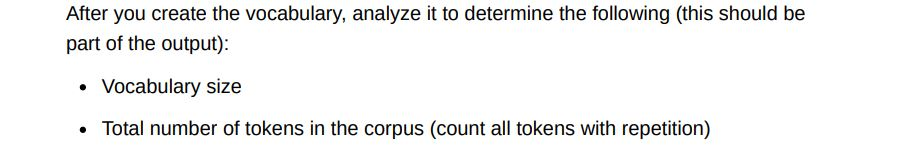

In [85]:
len(word_level_tokenizer.vocab)

6625

In [86]:

vocab_counts = Counter(all_tokens)

vocab_counts

Counter({'وفي': 245,
         'النهايه': 43,
         'معك': 210,
         'الجمال': 110,
         'روحك': 60,
         'نفسه': 136,
         'عالي': 28,
         'ترضي': 35,
         'بغير': 49,
         'مجرد': 78,
         'ساعات': 72,
         'الوصول': 19,
         'ت': 136,
         'الشيء': 342,
         'الوحيد': 411,
         'وصلوا': 320,
         'للعالميه': 318,
         'المسيار': 325,
         'كانوا': 388,
         'يشجعون': 321,
         'مدريد': 335,
         'ضد': 438,
         'لاتحسبونا': 43,
         'نسينا': 51,
         'يالطواقي': 45,
         'ولانبيكم': 43,
         'توقفون': 47,
         'معنا': 120,
         'ماحنا': 46,
         'بحاجت': 43,
         'جماهير': 182,
         'مسيار': 49,
         'الايام': 250,
         'شجعت': 45,
         'الكوري': 50,
         'احبك': 243,
         'وياه': 14,
         '🎶': 165,
         'جل': 111,
         'جلاله': 112,
         '': 2519,
         'بواد': 78,
         'زرع': 82,
         '💫': 345,
         '✍': 152,
    

In [87]:
print("Total number of all tokens in the corpus {}".format(len(all_tokens)))
print("Total number of word level tokens {}".format(len(word_level_tokens)))
print("Total number of word level tokenizer {}".format(len(word_level_tokenizer.vocab)))


Total number of all tokens in the corpus 343166
Total number of word level tokens 7836
Total number of word level tokenizer 6625


In [88]:
word_level_tokenizer.vocab

{'وفي': 2,
 'النهايه': 3,
 'معك': 4,
 'الجمال': 5,
 'روحك': 6,
 'نفسه': 7,
 'عالي': 8,
 'ترضي': 9,
 'بغير': 10,
 'مجرد': 11,
 'ساعات': 12,
 'الوصول': 13,
 'ت': 14,
 'الشيء': 15,
 'الوحيد': 16,
 'وصلوا': 17,
 'للعالميه': 18,
 'المسيار': 19,
 'كانوا': 20,
 'يشجعون': 21,
 'مدريد': 22,
 'ضد': 23,
 'لاتحسبونا': 24,
 'نسينا': 25,
 'يالطواقي': 26,
 'ولانبيكم': 27,
 'توقفون': 28,
 'معنا': 29,
 'ماحنا': 30,
 'بحاجت': 31,
 'جماهير': 32,
 'مسيار': 33,
 'الايام': 34,
 'شجعت': 35,
 'الكوري': 36,
 'احبك': 37,
 'وياه': 38,
 '🎶': 39,
 'جل': 40,
 'جلاله': 41,
 '': 42,
 'بواد': 43,
 'زرع': 44,
 '💫': 45,
 '✍': 46,
 'ومع': 47,
 'هتف': 48,
 'بالدعاء': 49,
 'وارزقهم': 50,
 'الثمرات': 51,
 'مهماكانت': 52,
 'ظرو': 53,
 'المطر': 54,
 '💃': 55,
 'خلونا': 56,
 '😆': 57,
 'فيروز': 58,
 'خلنا': 59,
 'تح': 60,
 'امين': 61,
 'العالمين': 62,
 'انتي': 63,
 'سيدنا': 64,
 'صل': 65,
 'وسلم': 66,
 'اجمعين': 67,
 'دا': 68,
 'ديل': 69,
 '💚': 70,
 '😅': 71,
 'استغفر': 72,
 'السلام': 73,
 'عليكم': 74,
 'ورحمه': 75,
 'وبركاته': 7

In [ ]:
from google.colab import files
import os
import json
import pickle


word_level_vocab_path = os.path.join('/drive/My Drive/', "word-level-vocab.json") 
with open(word_level_vocab_path, "wt+") as f:
    json.dump(word_level_tokenizer.vocab, f)

#files.download(word_level_vocab_path)


In [89]:
tweets = data["clean_stemmed"].tolist()
tweets

['وفي نهي معك جمل روح',
 'نفس',
 'علي ترض بغر جرد ساع وصل ت',
 'شيء وحد وصل علم سير كان شجع درد ضد',
 'حسبو نسي يالطواقي لنب وقف عنا ماح بحج جماهير سير ايم شجع كور',
 'احب ويه 🎶',
 'جل جلل   بود زرع 💫 💫 ✍ ومع هتف دعء رزق ثمر مهماكانت ظرو',
 'وين مطر 💃 خلو 😆 يرز خلن تح',
 'امن علم انت سيد صل سلم جمع',
 'دا ديل 💚',
 '😅 غفر',
 'ورخ طار',
 'سلم علي رحم وبر سعد وقت بكل قرن كرم سور',
 'حي شيخ سيد',
 'ايف رفق طبق شرط 👇',
 'ارب نتج اهل في غير 💟 حله',
 'عمر ترا لبس فيك يهد فلس ع',
 'رجل برا بري',
 'لا فكر لا ﻋ ﻠ ﻰ بلك علي لا',
 'شوف اله',
 'در قلب سمع 🍃 ور',
 'كفو جمهور شمس',
 'صبح ندي سعد بطل خلل وسم 👇 🏆 دور سعد',
 'بكر صدر رجع',
 'طهر صبح صبح سلم لهم حزن فتح بوب سعد',
 'جمل عبد',
 'عجيب وار لطف رحم قضء وار كرم قدر علق قلب من',
 'عين جمل فتح لوج',
 'سيس شخص وحد قدر يغر راي 😇',
 'لهم اني سلك كله عجل وجل علم اعلمواعوذ لشر كله عجل وجل علم ❀',
 'ايم زمن جمل',
 'احد دفع',
 'صرت با 🐰',
 'جمع ولم جيد',
 'غسل قبر حبب برد طيب 💚',
 'صبح سعد',
 'ايف 📱 تبع وثق فدو',
 'يجي غير هنا حب غير بكل 💖',
 'لحظ محل 

In [ ]:
#def tokenizee(documents):
#     return [tokenize_document(document) for document in documents]

#def tokenize_document( document):
#     return [vocab.get(token, -1) for token in document.split(" ")]

In [92]:
tokenizer = WordLevelTokenizer(corpus= data["clean_stemmed"].astype(str),min_frequency=12)
tokenized_tweets= tokenizer.tokenize(data["clean_stemmed"].astype(str).tolist())

num_samples = len(tokenized_tweets)
vocab_size = len(tokenizer.vocab)
num_samples,vocab_size


(56791, 3179)

In [93]:
tokenized_tweets

[[2, 3, 4, 5, 6],
 [7],
 [8, 9, 10, 11, 12, 13, 14],
 [15, 16, 13, 17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28, 29, 30, 31, 18, 32, 20, 33],
 [34, 35, 36],
 [37, 38, 39, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50],
 [51, 52, 53, 54, 55, 56, 57, 58],
 [59, 17, 60, 61, 62, 63, 64],
 [65, 66, 67],
 [68, 69],
 [-1, 70],
 [63, 8, 71, 72, 73, 74, 75, 76, 77, 78],
 [79, 80, 61],
 [81, 82, 83, 84, 85],
 [86, 87, 88, 89, 90, 91, 92],
 [93, 94, 95, 96, 97, 98, 99],
 [100, 101, 102],
 [103, 104, 103, 105, 106, 107, 108, 8, 103],
 [109, 110],
 [111, 112, 113, 114, 115],
 [116, 117, 118],
 [119, 120, 73, 121, 122, 123, 85, 124, 125, 73],
 [126, 127, 128],
 [129, 119, 119, 63, 130, 131, 132, 133, 73],
 [5, 134],
 [-1, 135, 136, 71, 137, 135, 77, 138, 139, 112, 140],
 [141, 5, 132, -1],
 [142, 143, 16, 138, 144, 145, 146],
 [130, 147, 148, 149, 150, 151, 17, 152, 153, 149, 150, 151, 17, 154],
 [32, 155, 5],
 [156, 157],
 [158, 159, -1],
 [64, 160, 161],
 [162, 163, 164, 165, 166, 67],
 

End Step 2

## Step 3 : Encoding

TF-IDF (Statistical Model )

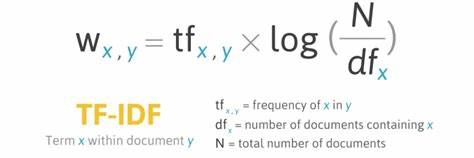

In [ ]:

#word_level_tokenizerrr = WordLevelTokenizer(corpus=tweets, min_frequency=8)
#tweets = data["clean_stemmed"].tolist()
#tokenized_tweetsss= word_level_tokenizerrr.tokenize(tweets)

#df = np.zeros(len(word_level_tokenizerrr.vocab))

#counter = Counter()
#for tweet in tweets:
 #   unique_tokens = set([word for word in tweet.split(" ")])
 #   counter.update(unique_tokens)
    
#for index, token in word_level_tokenizerrr.vocab.items():
 #   if index !="[PAD]" and index !="[OOV]":
  #     df[index] = counter.get(token, 0) + 1
#

In [94]:
tfidf = TfidfVectorizer(max_features = 4500)
X_train_tfidf = tfidf.fit_transform(data["clean_stemmed"].values.astype('U'))


In [95]:
feature_names = tfidf.get_feature_names()
count=0
for col in X_train_tfidf.nonzero()[1]:
    if count<20 :
       print (feature_names[col], ' - ', X_train_tfidf[0, col])
       count+=1

روح  -  0.43446453474491287
جمل  -  0.3468398100281407
معك  -  0.5023674790802262
نهي  -  0.45219465039865453
وفي  -  0.4838280979252309
نفس  -  0.0
وصل  -  0.0
ساع  -  0.0
جرد  -  0.0
بغر  -  0.0
ترض  -  0.0
علي  -  0.0
ضد  -  0.0
درد  -  0.0
شجع  -  0.0
كان  -  0.0
سير  -  0.0
علم  -  0.0
وحد  -  0.0
شيء  -  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


end step 3

# Modelling

##3.1.Statistical Model (KNN) whith TF_IDF

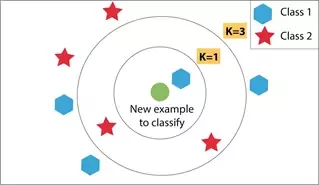

3.1.1.DataSet

In [96]:
test = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, test, test_size = 0.3, random_state = 0)


In [97]:
X_train.shape

(39753, 3082)

3.1.2.Model

In [98]:
knn = KNeighborsClassifier(n_neighbors=7)
model_knn = knn.fit(X_train, y_train)


###Evaluating

In [99]:
y_pred = model_knn.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[6727 1794]
 [3137 5380]]
              precision    recall  f1-score   support

         neg       0.68      0.79      0.73      8521
         pos       0.75      0.63      0.69      8517

    accuracy                           0.71     17038
   macro avg       0.72      0.71      0.71     17038
weighted avg       0.72      0.71      0.71     17038

0.7105880971945064


Text(0, 0.5, 'Error Rate')

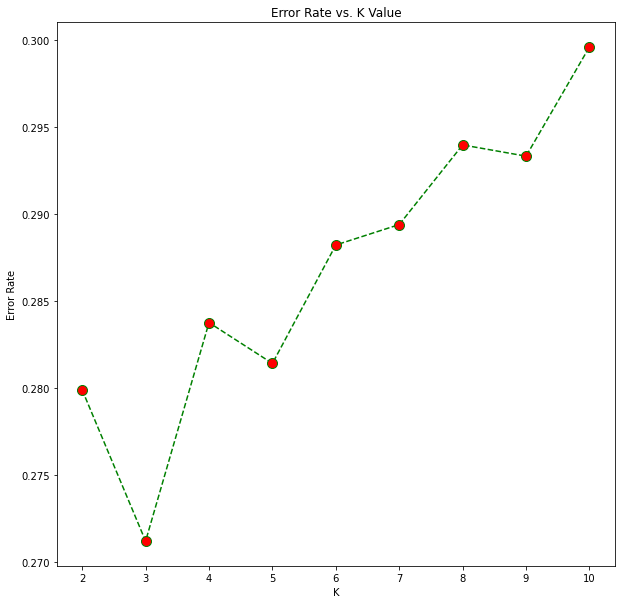

In [105]:
error_rate = []

for i in range(2, 11):
     
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
 
plt.figure(figsize =(10, 10))
plt.plot(range(2, 11), error_rate, color ='green',
                linestyle ='dashed', marker ='o',
         markerfacecolor ='red', markersize = 10)
 
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

##3.2.Deep learning model

3.1.1.DataSet

In [128]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [129]:
sentences = data["clean_text"].to_numpy()
labels = data["Sentiment"].replace({"neg": 0,"pos": 1}).to_numpy()


In [130]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25) 
print("Training Data Input Shape: ", X_train.shape) 
print("Training Data Output Shape: ", y_train.shape) 
print("Testing Data Input Shape: ", X_test.shape) 
print("Testing Data Output Shape: ", y_test.shape) 

Training Data Input Shape:  (42593,)
Training Data Output Shape:  (42593,)
Testing Data Input Shape:  (14198,)
Testing Data Output Shape:  (14198,)


In [131]:
len(tokenizer.vocab)

3179

In [144]:
#vocab=word_level_tokenizer.vocab
#len(tokenizer.vocab)
#tokenizer = WordLevelTokenizer(corpus= data["clean_stemmed"].astype(str), min_frequency=12)
OOV_TOKEN = "[OOV]"
PAD_TOKEN = "[PAD]"
BATCH_SIZE=15
#OOV_INDEX = vocab.get(OOV_TOKEN)
#vocab_size=len(word_level_tokenizer.vocab)


tokenizer_model = Tokenizer(num_words=len(tokenizer.vocab), oov_token=OOV_TOKEN)




In [145]:
tokenizer_model.fit_on_texts(X_train) 
print("Number of Documents: ", tokenizer_model.document_count) 
print("Number of Words: ", tokenizer_model.num_words)


Number of Documents:  42593
Number of Words:  3179


In [146]:
tokenizer_model.word_counts

OrderedDict([('يامدلل', 18),
             ('ماودك', 21),
             ('بهالمطر', 18),
             ('نتبلل', 18),
             ('ونعيد', 20),
             ('زمان', 105),
             ('الطيش', 18),
             ('نتراقص', 18),
             ('ونتعلل', 18),
             ('بعضنا', 25),
             ('نتجمل', 18),
             ('بدون', 234),
             ('عيب', 83),
             ('وليش', 30),
             ('❤', 257),
             ('الثلاثه', 134),
             ('اتفه', 132),
             ('العروس', 150),
             ('كريهه', 130),
             ('شو', 227),
             ('الام', 310),
             ('ركبت', 136),
             ('العريس', 150),
             ('دراما', 132),
             ('حبتين', 142),
             ('طلقها', 157),
             ('عشي', 130),
             ('تافه', 139),
             ('نشبه', 132),
             ('لزقه', 128),
             ('🙁', 84),
             ('الشي', 42),
             ('معقول', 25),
             ('انو', 294),
             ('يفوز', 46),
             ('يستر'

In [147]:
tokenizer_model.word_docs

defaultdict(int,
            {'ونعيد': 20,
             'وليش': 29,
             'زمان': 105,
             'بدون': 230,
             'ونتعلل': 18,
             'عيب': 80,
             'يامدلل': 18,
             'بهالمطر': 18,
             'نتبلل': 18,
             '❤': 218,
             'ماودك': 21,
             'بعضنا': 24,
             'نتجمل': 18,
             'نتراقص': 18,
             'الطيش': 18,
             'حبتين': 142,
             'كريهه': 130,
             'اتفه': 131,
             'الثلاثه': 134,
             'العروس': 150,
             'لزقه': 128,
             'طلقها': 157,
             'نشبه': 131,
             'شو': 224,
             'عشي': 130,
             'دراما': 132,
             'الام': 176,
             'ركبت': 135,
             'تافه': 139,
             'العريس': 148,
             '🙁': 84,
             'معقول': 25,
             'الشي': 42,
             'انو': 289,
             'يفوز': 43,
             'يستر': 65,
             'بطل': 63,
             'شاءالله': 

In [148]:

train_sequences = tokenizer_model.texts_to_sequences(X_train)
print(train_sequences[0])


[1, 2860, 1, 1, 2988, 479, 1, 1, 1, 2391, 1, 121, 625, 1986, 89]


In [150]:
MIN_LENGTH = 0
MAX_LENGTH = np.percentile([len(tweet) for tweet in  tokenized_tweets], q=99)
train_padded = pad_sequences(train_sequences, maxlen=int(MAX_LENGTH), padding='post', truncating='post')
test_sequences =  tokenizer_model.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=int(MAX_LENGTH), padding='post', truncating='post')


In [151]:

train_padded.shape,y_train.shape
test_padded.shape, y_test.shape

((14198, 19), (14198,))

In [152]:
model = Sequential()
#len(tokenizer.index_word)+1
embedding_dim = 16
model.add(Embedding(len(tokenizer.vocab), embedding_dim, input_length=int(MAX_LENGTH)))
lstm_out = 32
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 16)            50864     
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 64,069
Trainable params: 64,069
Non-trainable params: 0
_________________________________________________________________
None


In [153]:
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test))


Epoch 1/10
1332/1332 [==============================] - 28s 18ms/step - loss: 0.4623 - accuracy: 0.7549 - val_loss: 0.4073 - val_accuracy: 0.7917
Epoch 2/10
1332/1332 [==============================] - 23s 17ms/step - loss: 0.3789 - accuracy: 0.8106 - val_loss: 0.3991 - val_accuracy: 0.8023
Epoch 3/10
1332/1332 [==============================] - 29s 22ms/step - loss: 0.3577 - accuracy: 0.8234 - val_loss: 0.3864 - val_accuracy: 0.8084
Epoch 4/10
1332/1332 [==============================] - 22s 17ms/step - loss: 0.3328 - accuracy: 0.8363 - val_loss: 0.3867 - val_accuracy: 0.8110
Epoch 5/10
1332/1332 [==============================] - 22s 17ms/step - loss: 0.3129 - accuracy: 0.8464 - val_loss: 0.3974 - val_accuracy: 0.8079
Epoch 6/10
1332/1332 [==============================] - 23s 17ms/step - loss: 0.2949 - accuracy: 0.8560 - val_loss: 0.4130 - val_accuracy: 0.8088
Epoch 7/10
1332/1332 [==============================] - 23s 17ms/step - loss: 0.2784 - accuracy: 0.8617 - val_loss: 0.4180 -

In [154]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.462305  0.754889  0.407292      0.791661
1  0.378898  0.810556  0.399091      0.802296
2  0.357655  0.823445  0.386365      0.808424
3  0.332813  0.836264  0.386702      0.811030
4  0.312874  0.846383  0.397415      0.807860
5  0.294874  0.855962  0.412985      0.808776
6  0.278433  0.861738  0.418025      0.807579
7  0.264854  0.866692  0.431340      0.808987
8  0.251977  0.872773  0.466232      0.809551
9  0.240092  0.876106  0.478240      0.803282


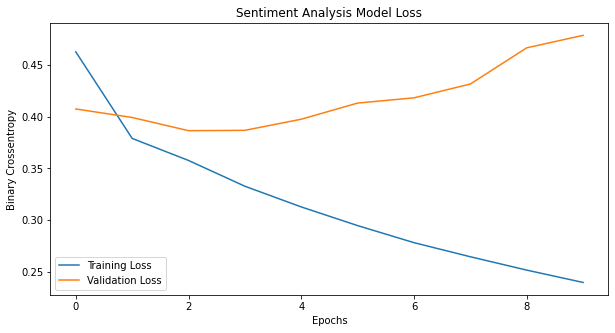

In [156]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Sentiment Analysis Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

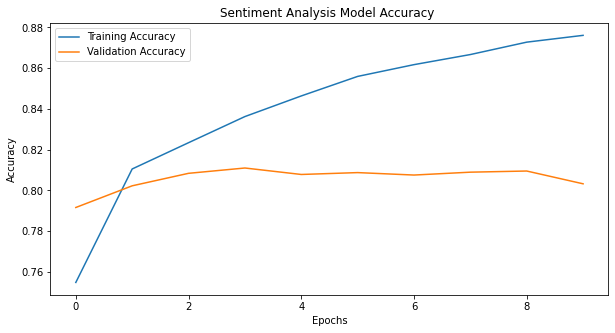

In [157]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('Sentiment Analysis Model Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()